In [1]:
%load_ext autoreload

# Traces simulator v2

In [47]:
N_USERS = 200

In [48]:
%autoreload
from tracer.simulator import TraceSimulator

sim = TraceSimulator(
    number_towers=900,
    number_users=N_USERS,
    number_cycles=24,
    expander=1,
    sigma=0.00025,
    vel_friction=0.9,
#     method='distance_square',
#     distance_power=20,
    verbose=True,
)

## Generate random user traces

In [49]:
sim.generate()

Took 0.024829864501953125 to create distrances matrix
Took 3.9989659786224365 to create probabilities matrix
Took 0.311229944229126 to create user traces
Took 0.0162200927734375 to build aggregated data
Took 4.351957082748413 to generate all


In [50]:
sim.traces.shape

(200, 24)

## Plot generated results

### Towers positions

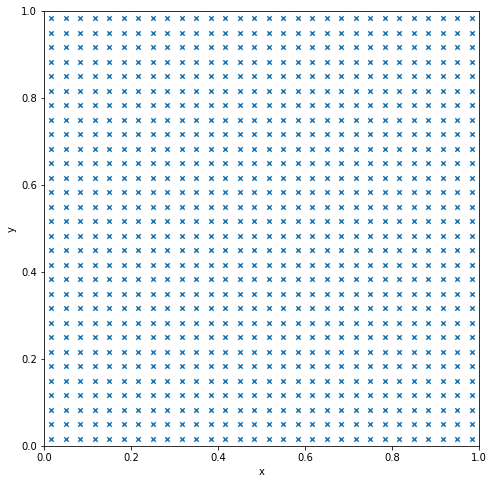

In [51]:
sim.towers_manager.plot_towers(annotate_towers=False);

### User trace

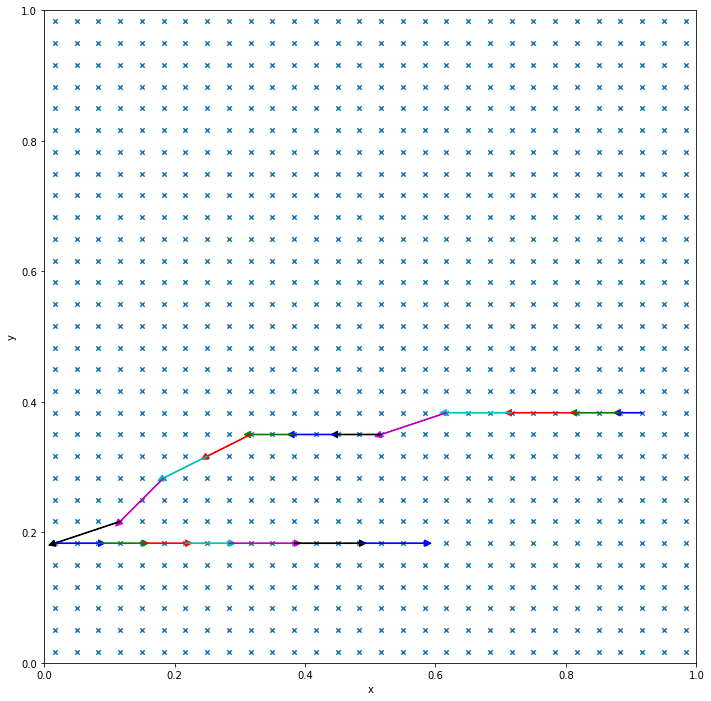

In [52]:
sim.towers_manager.plot_user_trace(sim.traces[2], annotate_towers=False)

In [53]:
sim.aggregated_data.shape

(24, 900)

In [54]:
import numpy as np
np.argmin(np.sqrt(np.sum((sim.towers_manager.towers - [0.5, 0.1]) ** 2, axis=1)))

423

In [55]:
from tracer.utils import distance

In [56]:
np.argmin([distance([0.5, 0.1], x) for x in sim.towers])

423

# Trajectory recovery

In [57]:
%autoreload
import numpy as np
from tracer.recover import TrajectoryRecovery

tr = TrajectoryRecovery(
    number_users=N_USERS,
    towers=sim.towers,
    aggregated_data=sim.aggregated_data,
    vel_friction=0.9
)

In [58]:
tr.build_distribution_matrix()

In [59]:
tr.L.shape

(24, 200)

## Recover trajectories

Recovers the trajectories for each anonymous user and the costs on each step

In [60]:
res = tr.trajectory_recovery_generator()

Recovering: 100%|██████████| 24/24 [00:03<00:00,  7.67it/s]


In [61]:
# res['recovered_costs']

In [62]:
# tr.towers_manager.plot_user_trace(res['recovered_trajectories'][:, 1])

## Map recovered trajectories with real trajectories

global_accuracy = $\frac{1}{N} \sum_{i=1}^N \frac{|T_i \cap Y_i|}{|Y_i|}$

In [63]:
mapping, global_accuracy, acc, error = tr.map_traces(sim.traces, mapping_style='accuracy')

Mapping: 100%|██████████| 200/200 [00:00<00:00, 202.03it/s]


In [64]:
global_accuracy

0.34625

For each recovered trajectory, see how many elements it has in common with the real one

In [65]:
# dict(enumerate(acc)), dict(enumerate(error))
dict(enumerate(mapping))
len(mapping) == len(set(mapping))

True

In [66]:
np.mean(error)

5.231049323862092

User 26 mapped to simulated trace 187


<Figure size 432x288 with 0 Axes>

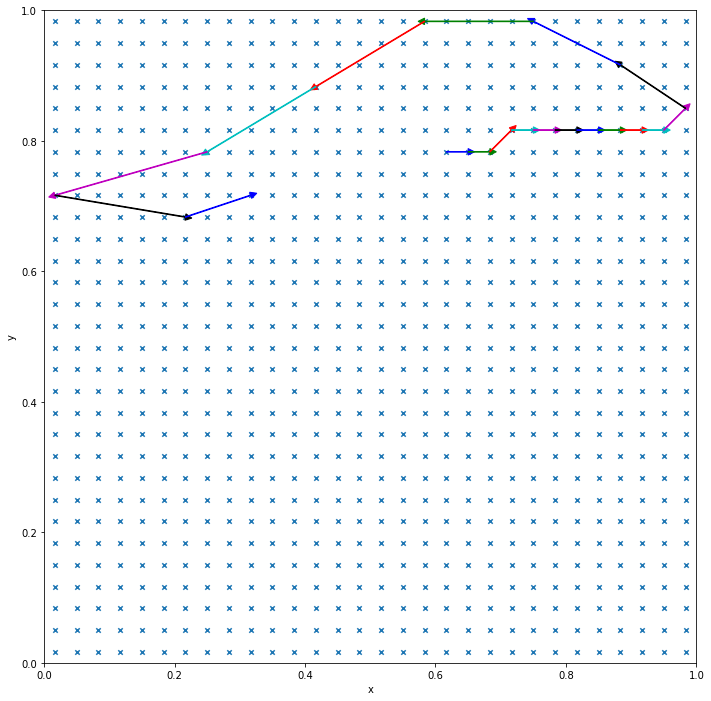

<Figure size 432x288 with 0 Axes>

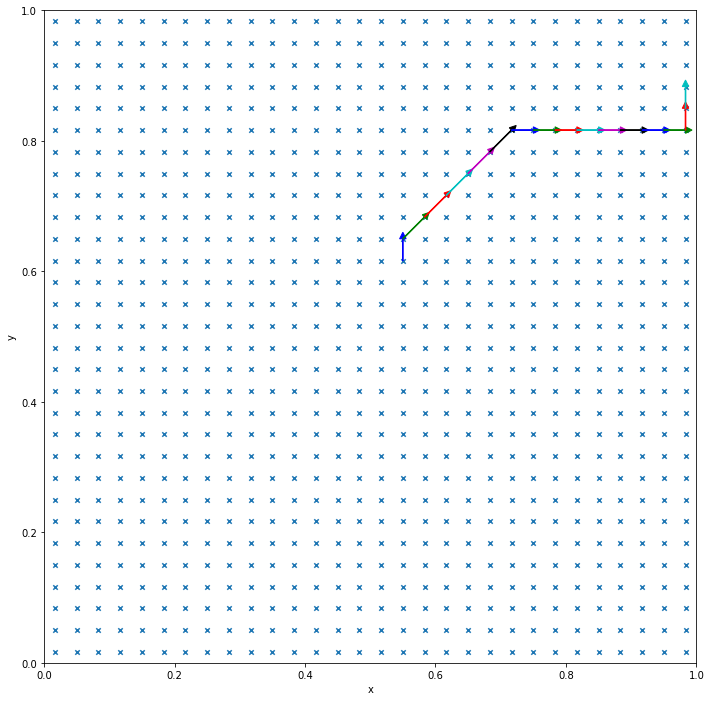

In [67]:
user = 26
recovered_trace = tr.S.T[user]
print(f'User {user} mapped to simulated trace {mapping[user]}')
mapped_trace = sim.traces[mapping[user]]

import matplotlib.pyplot as plt

plt.figure()
tr.towers_manager.plot_user_trace(recovered_trace, annotate_towers=False)

plt.figure()
tr.towers_manager.plot_user_trace(mapped_trace, annotate_towers=False)

# Performing accuracy analysis with random starting point

To be sure that the greedy method is not driving us into local minimum values

In [68]:
k_analysis = tr.map_traces_analysis(sim.traces, mapping_style='accuracy', k=30, n_jobs=-1)

Mapping: 100%|██████████| 200/200 [00:03<00:00, 64.35it/s]


In [69]:
overal_accuracy = sum([a[1] for a in k_analysis]) / 30

overal_accuracy, global_accuracy

(0.34079166666666677, 0.34625)